In [1]:
# import Pkg
# Pkg.instantiate()
# Pkg.update()
# Pkg.resolve()

# Setup

In [2]:
#-Constants------------
const G₀ = 7.748091729e-5
const e = 1.602176634e-19
const h = 6.62607015e-34
const kb = 1.380649e-23
const Δ = 189e-6
#-config---------------
workers = nothing
#----------------------
;

In [3]:
#-configuration---------
transmissions = [0.005:0.005:1.0]
temp = (0,"Δ")
integration = (-15.0, 15.0)
voltage = (0.005, 0.005, 6.00)
filter_threshold = 0.01
#-----------------------
num_workers = 10
;

In [4]:
#-conversion------------
TΔ(TK) = (TK * kb) / (Δ*e)
TK(TΔ) = (TΔ * Δ * e) / kb

if temp[2] == "K"
    temp = TΔ(temp[1])
elseif temp[2] == "Δ"
    temp = temp[1]
else
    error("Invalid temperature unit. Use 'K' or 'Δ'.")
end
#-----------------------

0

In [5]:
#-checks----------------
if temp <= 0
    println("Temperature is 0.\n Assuming default value of 1e-7")
    temp = 1e-7
end

@assert voltage[1] >= 0.005 "Voltage must be greater or equal to 0.005"
#----------------------

Temperature is 0.
 Assuming default value of 1e-7


In [6]:
#-dependencies----------
using ProgressMeter
using Plots
using JLD2
using Distributed
using CairoMakie
using ColorSchemes

using DrWatson
@quickactivate
include(srcdir("Utilities.jl"))
#----------------------

Main.Utilities

In [7]:
# convert input parameters
transmissions = vcat([collect(t) for t in transmissions]...)
voltages = collect(voltage)

# find working dirs
start_dir = @__DIR__
temp_dir = joinpath(@__DIR__, "..", "temp")
bin_dir = joinpath(@__DIR__, "..", "bin")
plots_dir = joinpath(@__DIR__, "..", "plots")
data_dir = joinpath(@__DIR__, "..", "data")
;

# Calculation

In [8]:
# cd(temp_dir)
# for i in 1:num_workers
#    run(`mkdir -p thread_$i`)
#    run(`cp $bin_dir/iv $temp_dir/thread_$i`)
#    open(joinpath(temp_dir,"thread_$i", "do.sh"), "w") do file
#       write(file, "cat temp_config.txt | ./iv")
#    end
#    run(`chmod +x $temp_dir/thread_$i/do.sh`)
# end

In [9]:
# if workers === nothing
#     workers = num_workers
#     addprocs(num_workers);
#     println("Added $num_workers workers.")
# end

In [10]:
# @everywhere using ProgressMeter
# @everywhere begin
#     using Serialization  # For sending complex data types

#     function run_simulation(i, t, temp, integration, voltage, temp_dir)
#         thread_dir = joinpath(temp_dir, "thread_$(myid()-1)")

#         run(`rm -f $(joinpath(thread_dir, "iv.dat"))`)
#         run(`rm -f $(joinpath(thread_dir, "temp_config.txt"))`)

#         open(joinpath(thread_dir, "temp_config.txt"), "w") do file
#             write(file, "  $t  $temp\n")
#             write(file, "$(integration[1])  $(integration[2])\n")
#             write(file, "  $(voltage[1])  $(voltage[3])  $(voltage[2])\n")
#         end

#         run(`bash -c "cd $(thread_dir) && ./do.sh"`)

#         x, y = Float64[], Float64[]

#         try
#             open(joinpath(thread_dir, "iv.dat"), "r") do file
#                 for line in eachline(file)
#                     parts = split(strip(line))
#                     if length(parts) >= 2
#                         push!(x, parse(Float64, parts[1]))
#                         push!(y, parse(Float64, parts[2]))
#                     end
#                 end
#             end
#         catch e
#             println("Error processing file for t=$t: $e")
#         end

#         return (t, (x, y))
#     end
# end

In [11]:
# curves = Dict{Float64, Tuple{Vector{Float64}, Vector{Float64}}}()
# args_list = [(i, transmissions[i], temp, integration, voltage, temp_dir) for i in 1:length(transmissions)]
# results = @showprogress 1 "Working..." pmap(x -> run_simulation(x...), args_list)

# for (t, data) in results
#     curves[t] = data
# end

# const raw = copy(curves);

In [12]:
# curve_processed = Dict{Float64,Tuple{Vector{Float64},Vector{Float64}}}()
# for (τ, curve) in curves
#     x, y = curve
#     x = copy(x)
#     y = copy(y)
#     G = G₀ * τ
#     y .*= (2*e^2*Δ/ h)
#     y ./= G
#     curve_processed[τ] = (x, y)
# end
# const normalized = copy(curve_processed);

# Cache
Load from Cache instead of recomputing

In [13]:
file = jldopen(joinpath(data_dir, "HighRes", "iv-T0.0K.jld2"), "r")
const loaded_raw = file["raw"]
const loaded_normalized = file["normalized"]
const loaded_derived = file["derived"]
if !isdefined(Main, :normalized)
    normalized = loaded_normalized
end
;

# Post-Processing

In [14]:
normalized = Dict{Float64, Tuple{Vector{Float64}, Vector{Float64}}}()
for (τ, curve) in loaded_normalized
    x, y = curve
    x = copy(x)
    y = copy(y)
    G = G₀ * τ
    y ./= (2*e^2*Δ/ h)
    y .*= 0.75E-4
    # y .*= G
    normalized[τ] = (x, y)
end

#### Setup Filter Check Display

In [15]:
fig = Figure(size = (1200, 800))
ax1 = Axis(fig[1,1])
ax2 = Axis(fig[2,1])
ax3 = Axis(fig[3,1])

Axis with 0 plots:


In [16]:
curve_filtered = Dict{Float64,Tuple{Vector{Float64},Vector{Float64}}}()
for (τ, curve) in normalized
    x, y = curve
    x = copy(x)
    y = Utilities.local_average((copy(x),copy(y)); threshold=100)
    lines!(ax1, x[1:end-1], Utilities.deriv1)
    lines!(ax2, x[1:end-2], Utilities.deriv2)
    lines!(ax3, x[1:end-3], Utilities.deriv3)
    curve_filtered[τ] = (x, y)
end
const filtered = copy(curve_filtered);

##### Display Filter Check

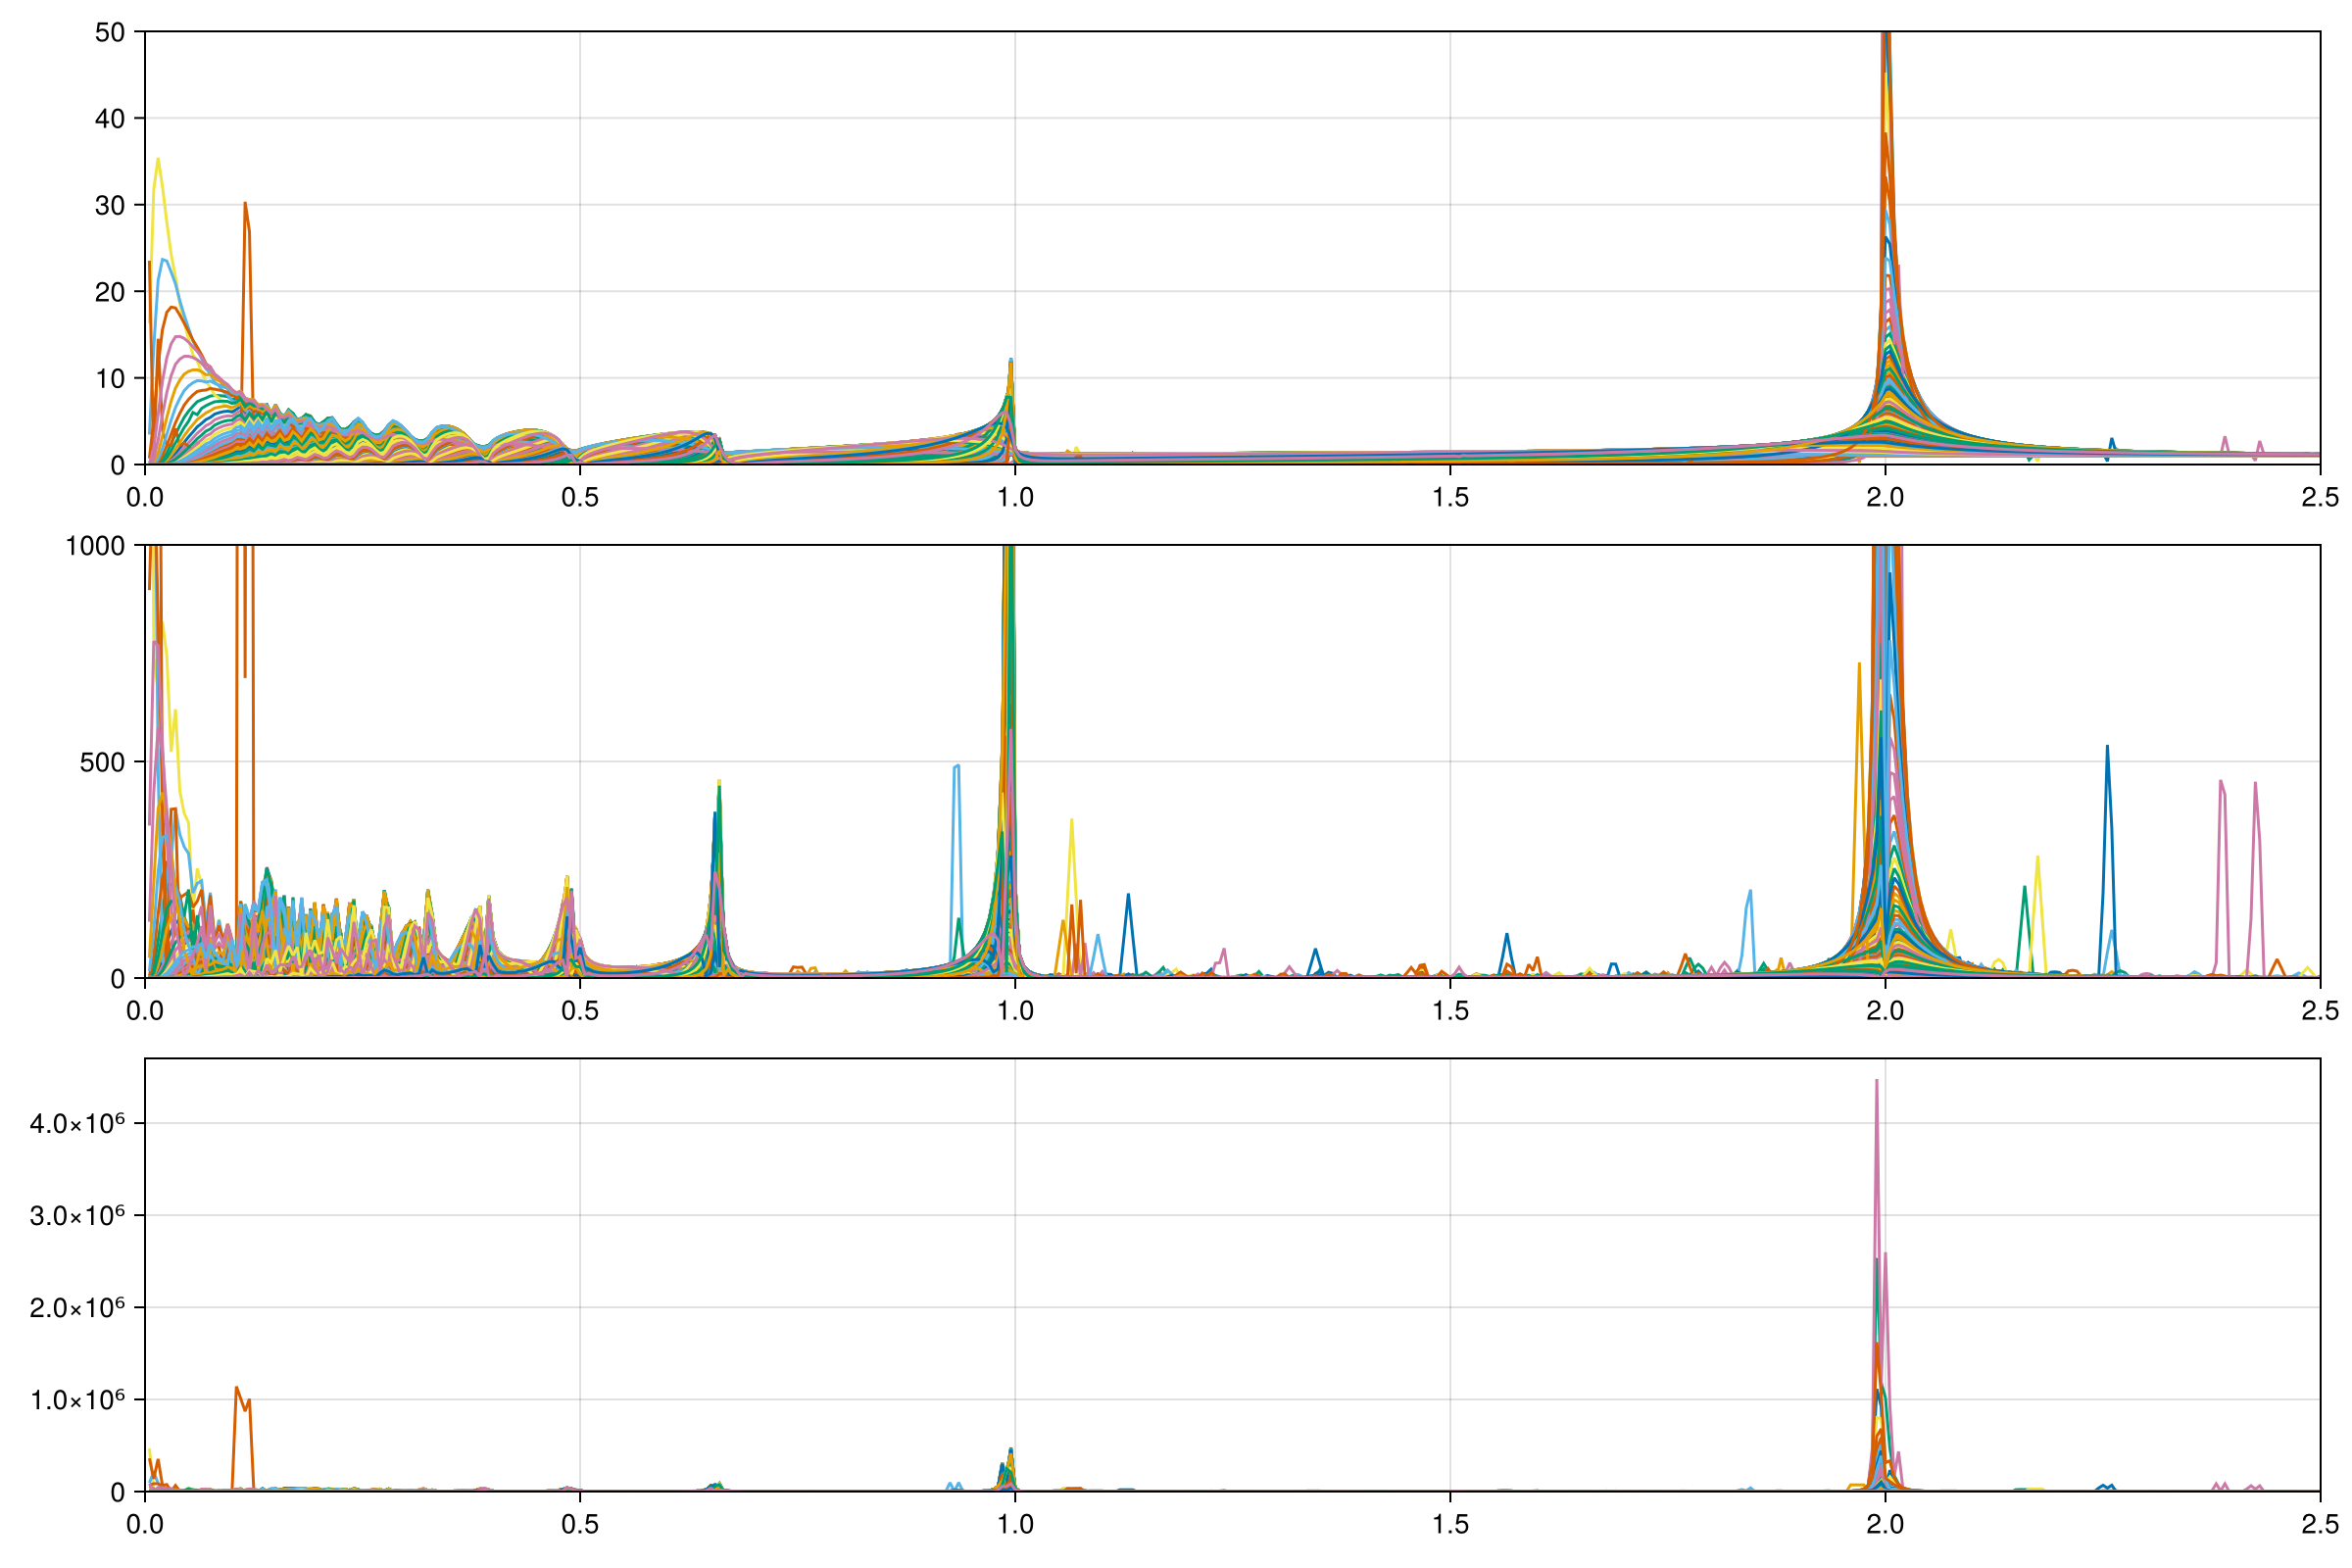

CairoMakie.Screen{IMAGE}


In [17]:
ax1.limits = (0,2.5,0,50)
ax2.limits = (0,2.5,0,1000)
ax3.limits = (0,2.5,0,nothing)
display(fig)

##### Compare Filtered and Unfiltered Data

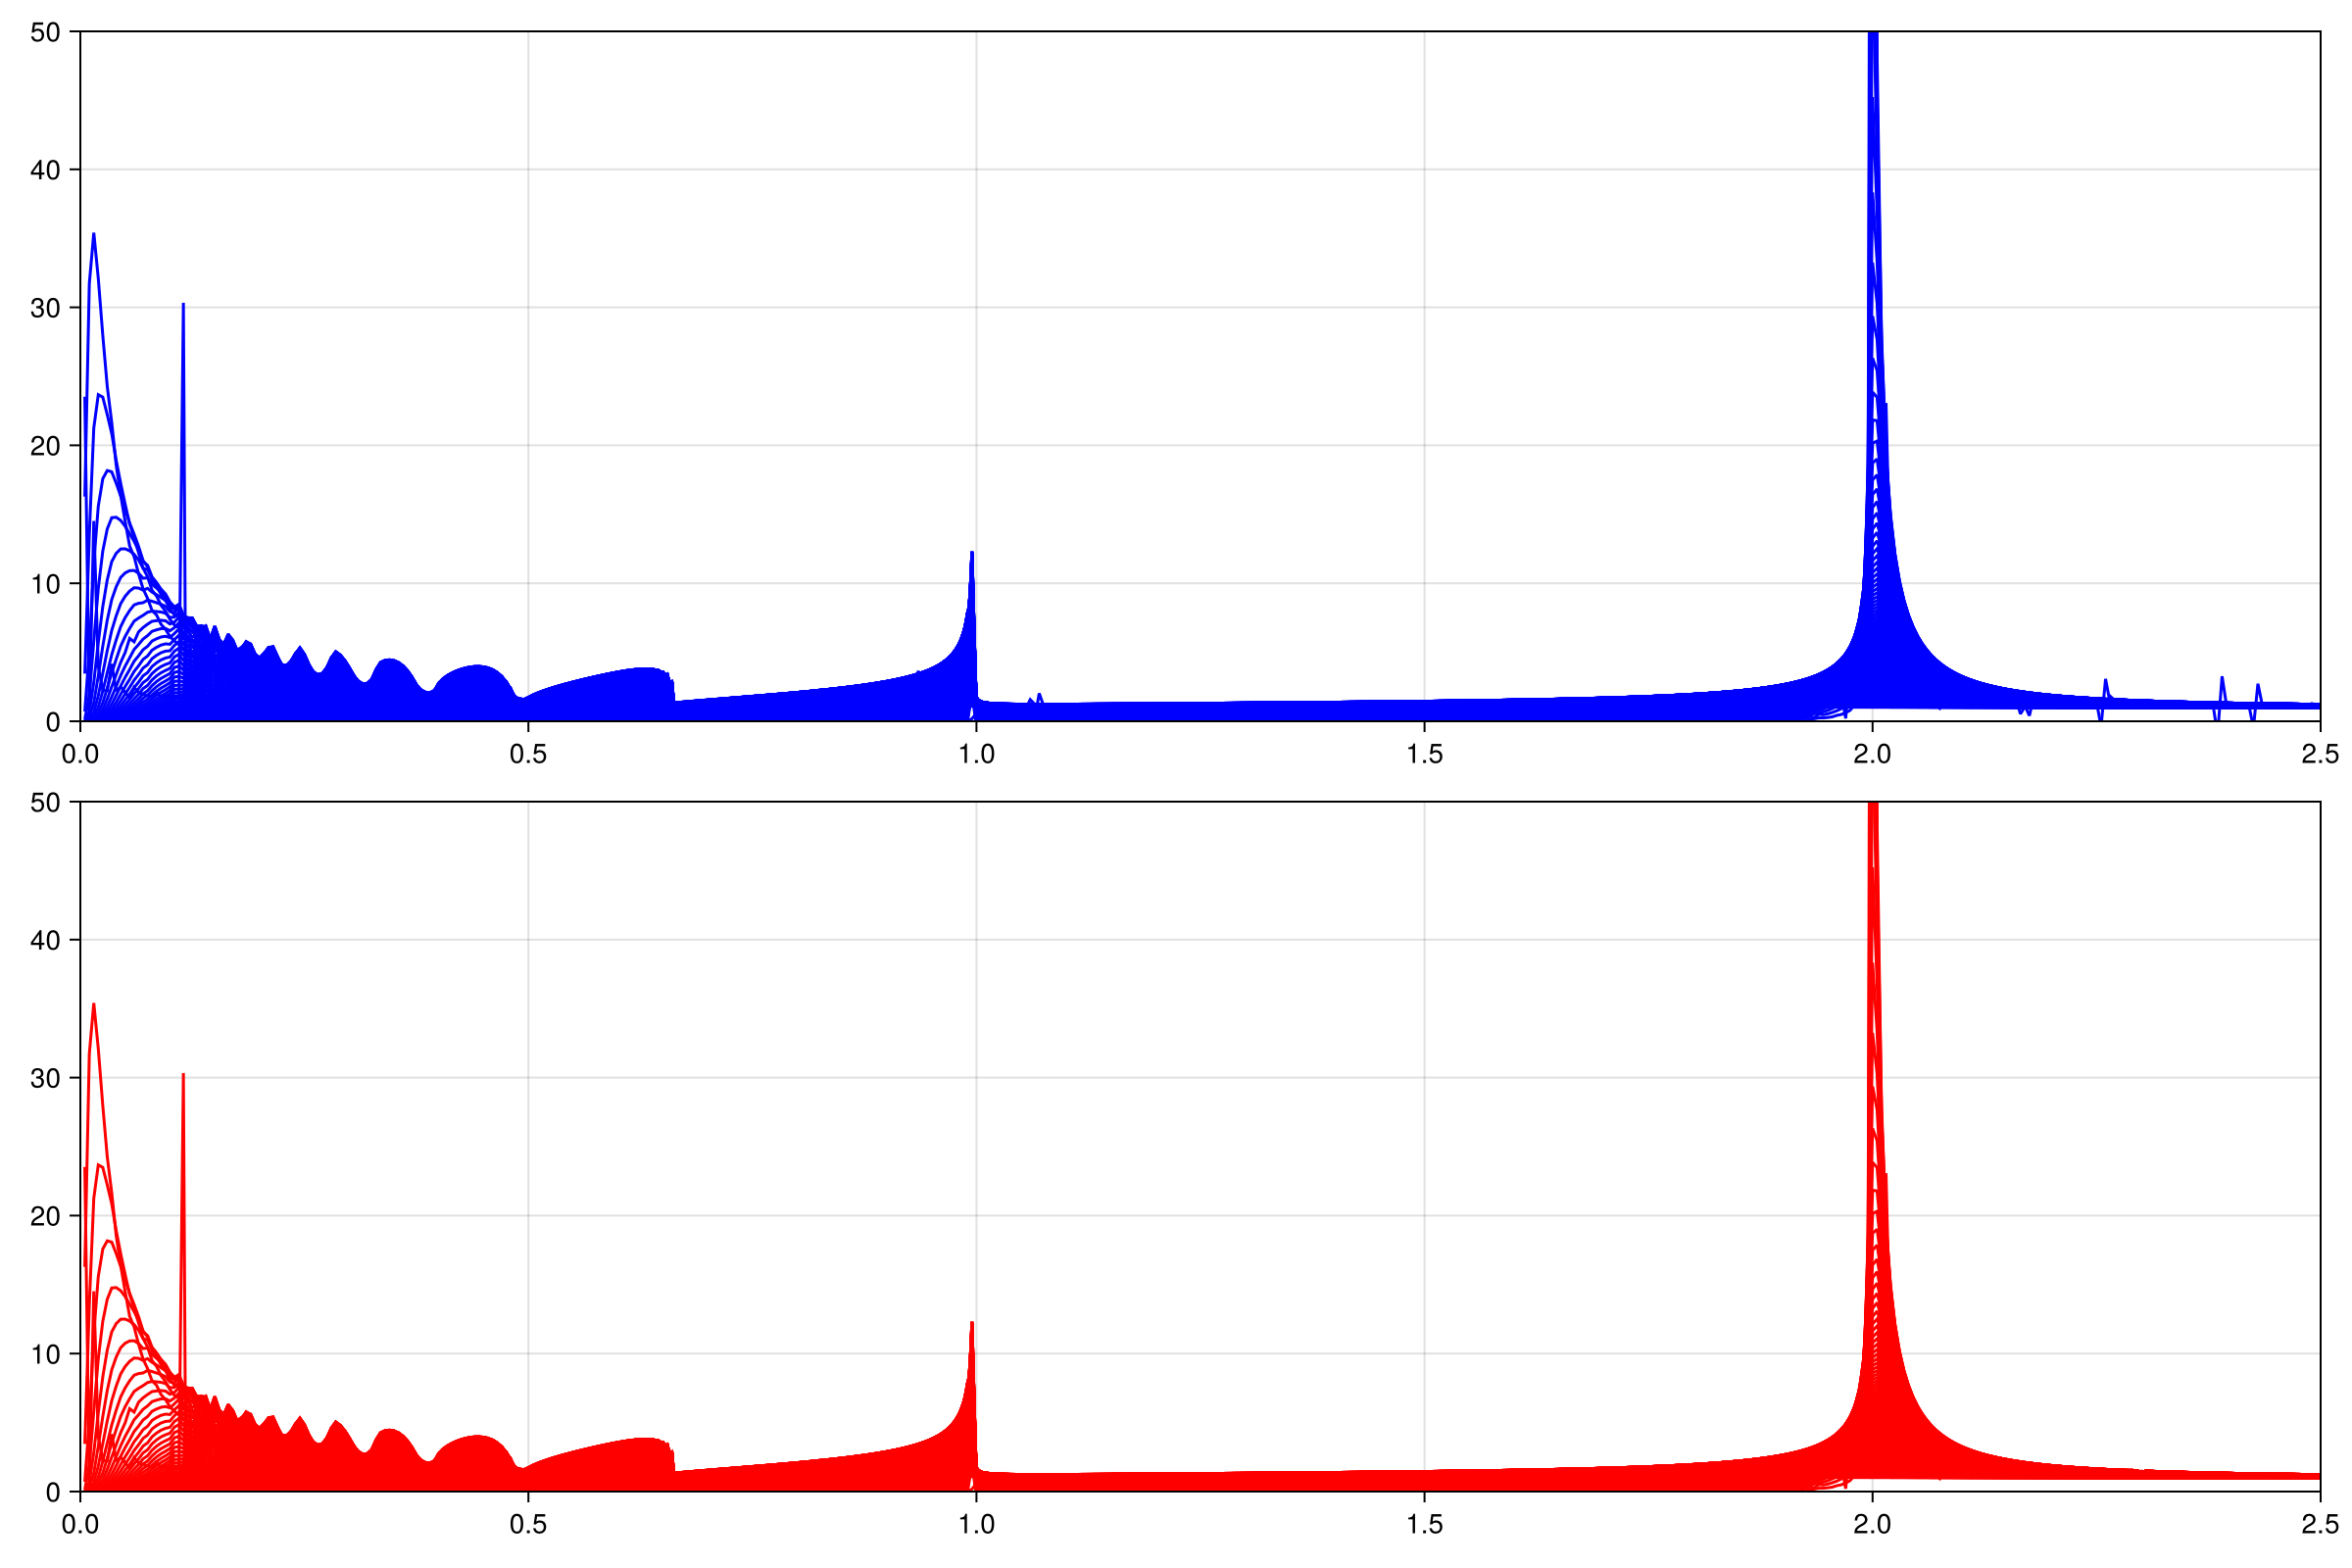

CairoMakie.Screen{IMAGE}


In [18]:
fig = Figure(size = (1200, 800))
ax1 = Axis(fig[1,1])
ax2 = Axis(fig[2,1])

for τ in sort(collect(keys(filtered)))
    c1 = normalized[τ]
    c2 = filtered[τ]
    x1, y1 = c1
    x2, y2 = c2
    y1 = diff(y1) ./ diff(x1)
    y2 = diff(y2) ./ diff(x2)
    x1 = x1[1:end-1]
    x2 = x2[1:end-1]
    lines!(ax1, x1, y1, label = "τ = $τ", color = :blue)
    lines!(ax2, x2, y2, label = "τ = $τ", color = :red)
end
ax1.limits = (0,2.5,0,50)
ax2.limits = (0,2.5,0,50)
display(fig)

## Continue Post-Processing

In [19]:
curve_derived = Dict{Float64,Tuple{Vector{Float64},Vector{Float64}}}()
for (τ, curve) in filtered
    x, y = curve
    y = diff(y) ./ diff(x)
    x = x[1:end-1]
    curve_derived[τ] = (x, y)
end
const derived = copy(curve_derived);

In [20]:
curve_d2 = Dict{Float64, Tuple{Vector{Float64}, Vector{Float64}}}()
for (τ, curve) in curve_filtered
    x, y = curve
    y = diff(y) ./ diff(x)
    x = x[1:end-1]
    curve_d2[τ] = (x, y)
end

In [21]:
# #-save results----------
jldopen(joinpath(data_dir, "IV-Carlos.jld2"), "w") do file
    # file["raw"] = raw
    file["normalized"] = normalized
    file["derived"] = derived
    file["filtered"] = filtered
    file["Temp"] = [(TK(temp), "K"),(temp, "Δ")];
end;
# -load results----------
# jldopen(joinpath(data_dir, "iv-T$(TK(temp))K.jld2"), "r") do file
#     raw = file["raw"]
#     normalized = file["normalized"]
#     derived = file["derived"]
# end;

2-element Vector{Tuple{Float64, String}}:
 (2.1932539249729654e-7, "K")
 (1.0e-7, "Δ")

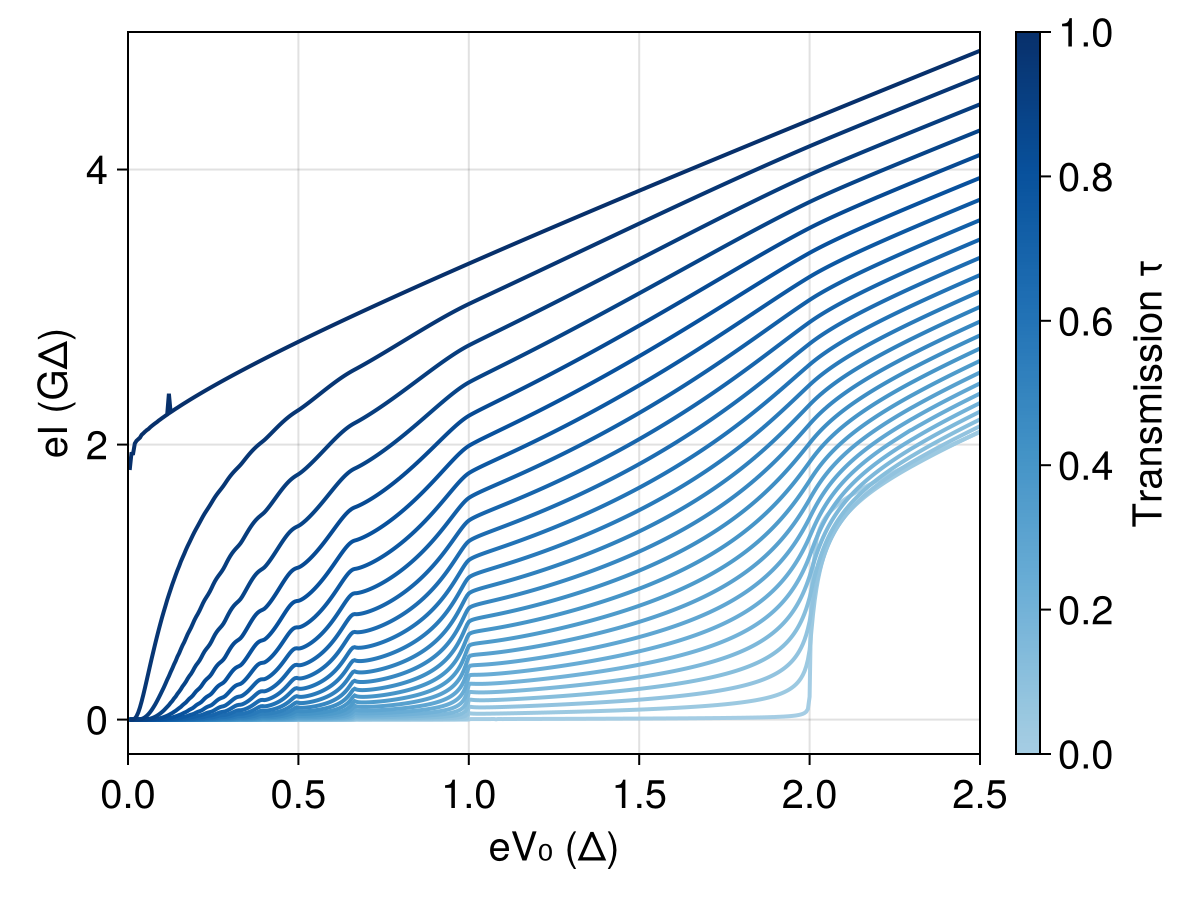

CairoMakie.Screen{IMAGE}


In [22]:
t_values = sort(collect(keys(filtered)))

max_clip = 1.0  
min_clip = 0.35

clip_normalize(t, min_val, max_val) = t_rel = min_val + t * (max_val - min_val)

see = get(ColorSchemes.Blues, range(min_clip, max_clip, length=256))

fig = Figure(fontsize = 20)
ax = Axis(fig[1, 1])

for (i, t) in enumerate(t_values)
    if (i - 1) % 8 != 0 && t != 1.0
        continue  # Skip the last value if it is 1.0, and only plot every 4th curve
    end

    x, y = filtered[t]
    color_idx = clip_normalize(t, min_clip, max_clip)
    lines!(ax, x, y, color=cgrad(:Blues)[color_idx], linewidth=2)
end
ax.xlabel = "eV₀ (Δ)"
ax.ylabel = "eI (GΔ)"
ax.limits = (0, 2.5, -0.25, 5)
ax.yticks = 0:2:7

Colorbar(fig[1, 2], colormap=see, ticks=0:0.2:1, label="Transmission τ")

display(fig)


In [23]:
save(joinpath(plots_dir, "Carlos-IV's.png"), fig)

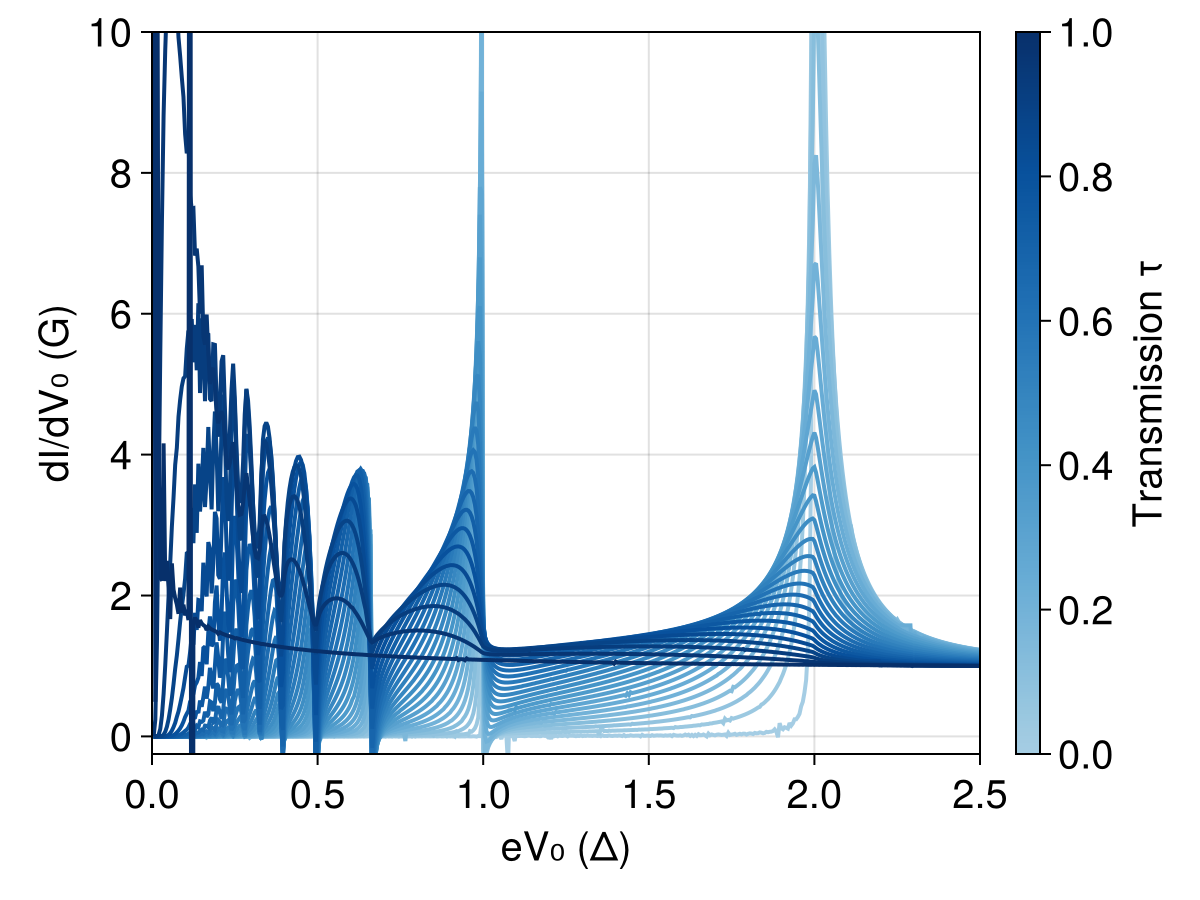

CairoMakie.Screen{IMAGE}


In [24]:
fig = Figure(fontsize = 20)
ax = Axis(fig[1, 1])

for (i,(τ, curve)) in enumerate(sort(collect(derived), by = x -> x[1]))
    if τ != 1.0 && (i - 1) % 8 != 0
        continue  # Skip the last value if it is 1.0
    end
    x, y = curve
    color_idx = clip_normalize(τ, min_clip, max_clip)
    lines!(ax, x, y, color=cgrad(:Blues)[color_idx], linewidth=2)
end
ax.xlabel = "eV₀ (Δ)"
ax.ylabel = "dI/dV₀ (G)"
ax.limits = (0, 2.5, -0.25, 10)
ax.yticks = 0:2:10

Colorbar(fig[1, 2], colormap=see, ticks=0:0.2:1, label="Transmission τ")
display(fig)

In [25]:
save(joinpath(plots_dir, "Carlos-dIdV.png"), fig)